In [19]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
DATA_FILE = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_stacks_tall.yaml"
#DATA_FILE = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes.yaml"
scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_FILE)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(3208, 5)
means:  [-0.00762129  0.32263564  0.01058186  0.20051912  0.20306821]
vars:  [0.45555539 0.23380552 1.0386428  0.05727169 0.05698   ]
2d_sphere : 
(463, 4)
means:  [0.03603112 0.3323627  0.04299577 0.09813612]
vars:  [0.50021995 0.27026922 4.30049124 0.02843935]


In [84]:
print len(scenes_dataset_yaml)

560


In [21]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(DATA_FILE, max_num_objects=20)
data = scenes_dataset.get_full_dataset()

In [22]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)
        
print "All params: ", pyro.get_param_store().get_all_param_names()
#interesting_params = ["keep_going_weights",
#                      "new_class_weights"]

model = MultiObjectMultiClassModelWithContext(scenes_dataset)
pyro.clear_param_store()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_stacks_untrained.pyro")
guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, guide, optim, loss=elbo)
losses = []
        
snapshots = {}
for i in range(501):
    # Guesses on important things:
    # Big subsamples appear really important -- I had major loss of
    # convergence when using smaller subsample sizes (like ~50).
    # Also important: prior on the variance must be REALLY low.
    # Otherwise long_box_mean diverges to negative... :(
    # I think there's a fundamental problem with variance estimation
    # under this guide / with this system -- see the single-box-dataset
    # estimates that don't capture the x vs y variance.
    loss = svi.step(data, subsample_size=250)
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    for p in pyro.get_param_store().keys():
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    if (i % 10 == 0):
        print loss
print "Done"

All params:  ['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'keep_going_weights', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$bias_hh_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generato

In [23]:
# Save model
# This isn't working and I'm not sure why...
print pyro.get_param_store().get_all_param_names()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_stacks_unstructured.pyro")

['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$bias_hh_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generator_module_1$$$2.weight', 'class_cont

In [14]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset)
model.model()
print pyro.get_param_store().get_all_param_names()
pyro.get_param_store().load("planar_multi_object_multi_class_2_with_context_stacks_unstructured.pyro")

['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$bias_hh_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generator_module_1$$$2.weight', 'class_cont

In [15]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_bin")
    time.sleep(1.0)

{'obj_0000': {'color': [0.7335745212042042, 0.0, 1.0, 1.0], 'pose': [-0.2345292866230011, 0.050783514976501465, 0.006295901723206043], 'params': [0.20319464802742004, 0.18976956605911255], 'class': '2d_box', 'params_names': ['height', 'length']}, 'n_objects': 1}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
{'obj_0002': {'color': [0.5229360558294268, 0.0, 1.0, 1.0], 'pose': [0.8907164335250854, 0.2739117741584778, -0.34103924036026], 'params': [0.09813404083251953], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.7803282532654174, 0.0, 1.0, 1.0], 'pose': [0.06369411945343018, -0.10606345534324646, -3.1729891300201416], 'params': [-0.08323650807142258], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0001': {'color': [0.5147302258766633, 0.0, 1.0, 1.0], 'pose': [-0.0352628268301487, 0.5692042708396912, -1.883277297019

[9, 7, 6, 6, 5, 12, 9, 2, 5, 4, 4, 6, 7, 4, 6, 10, 8, 17, 5, 5, 3, 7, 11, 4, 4, 18, 9, 11, 5, 8, 7, 15, 11, 5, 6, 16, 4, 8, 6, 4, 19, 12, 3, 4, 7, 9, 7, 2, 9, 20, 16, 7, 20, 7, 4, 20, 4, 13, 6, 12, 5, 15, 8, 9, 7, 2, 7, 11, 16, 9, 8, 6, 12, 5, 11, 7, 12, 8, 9, 4, 2, 5, 8, 7, 6, 7, 11, 16, 9, 6, 7, 12, 2, 10, 9, 9, 7, 19, 13, 10, 2, 5, 3, 3, 12, 2, 6, 19, 8, 12, 13, 7, 12, 5, 9, 8, 8, 11, 11, 4, 7, 7, 5, 11, 7, 18, 6, 12, 12, 10, 20, 9, 13, 14, 4, 9, 8, 3, 12, 5, 20, 10, 12, 13, 15, 14, 11, 8, 6, 5, 10, 5, 12, 11, 13, 9, 20, 2, 4, 11, 4, 5, 13, 8, 8, 6, 12, 11, 7, 9, 7, 4, 8, 5, 7, 11, 5, 13, 6, 15, 6, 13, 16, 6, 4, 11, 9, 8, 20, 12, 14, 8, 8, 11, 4, 6, 9, 10, 7, 5, 11, 6, 2, 1, 7, 12, 15, 10, 9, 11, 8, 8, 6, 10, 3, 16, 8, 5, 9, 4, 8, 7, 6, 7, 9, 8, 13, 5, 8, 13, 8, 6, 11, 6, 7, 12, 6, 5, 8, 5, 8, 12, 5, 2, 12, 7, 5, 10, 15, 3, 20, 2, 13, 10, 10, 7, 18, 7, 7, 12, 3, 3, 13, 8, 20, 8, 14, 9, 8, 3, 15, 5, 7, 4, 3, 13, 4, 7, 5, 11, 9, 13, 9, 5, 6, 12, 2, 5, 6, 10, 10, 11, 17, 5, 17, 10, 14,

(array([ 0.,  1., 22., 19., 39., 45., 39., 50., 45., 48., 30., 37., 38.,
        21., 11., 12., 12.,  5.,  9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

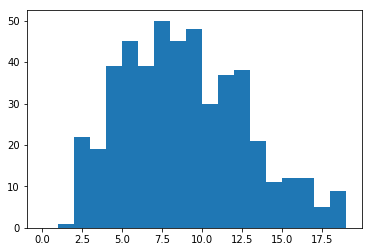

In [138]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(500):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    generated_n_objs.append(scene_yaml[0]["n_objects"])
print generated_n_objs
plt.hist(generated_n_objs, bins=range(20))

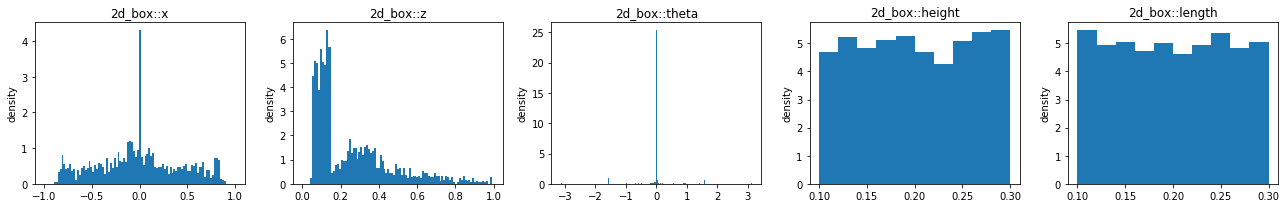

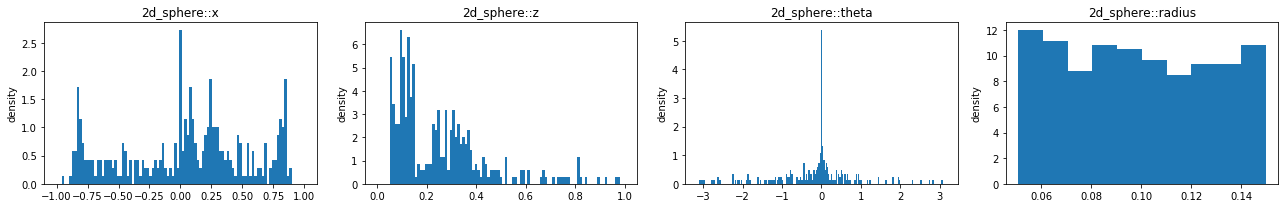

In [81]:
import matplotlib.pyplot as plt
from scipy.stats import norm

for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    params = np.stack(params_by_object_class[object_name]).copy()
    #params[2, :] = (params[2, :] % np.pi)
    for k in range(params.shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, params.shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        x_bins = plt.hist(params[:, k], label="Empirical", density=True, bins=bins)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        #plt.plot(x_range, norm.pdf(x_range, params_means[k], params_vars[k]), label="Learned")
        
    plt.tight_layout()
    

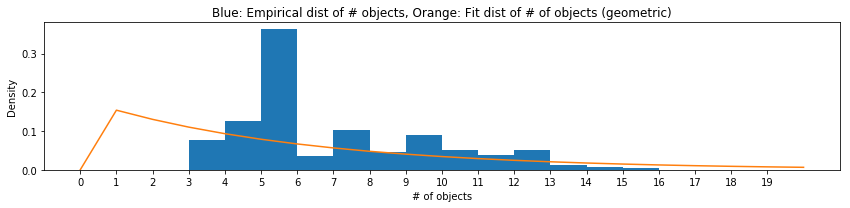

In [54]:
import scipy as sp
import scipy.stats
# Draw the keep_going CDF, which is the product of all previous keep_going vals.
keep_going_vals = pyro.param("keep_going_weights").detach().numpy().copy()
keep_going_pdf = np.zeros(keep_going_vals.shape[0])
for k in range(0, keep_going_pdf.shape[0]):
    keep_going_pdf[k] = np.prod(keep_going_vals[0:k])*(1. - keep_going_vals[k])
plt.figure().set_size_inches(12, 3)
plt.title("Blue: Empirical dist of # objects, Orange: Fit dist of # of objects (geometric)")
plt.xlabel("# of objects")
plt.ylabel("Density")
xbins = plt.hist([p["n_objects"] for p in scenes_dataset_yaml], bins=range(0, 21), density=True)[1]
plt.plot(xbins, sp.stats.geom.pmf(xbins, 1.-keep_going_vals[0]))
plt.xticks(range(20))
plt.tight_layout()

In [24]:
import yaml
noalias_dumper = yaml.dumper.SafeDumper
noalias_dumper.ignore_aliases = lambda self, data: True

while (1):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
        generated_data)[0]
    try:
        scene_nonpen, scene_static = dataset_utils.ProjectEnvironmentToFeasibility(
            scene_yaml, "planar_bin")

        print "Scene original"
        dataset_utils.DrawYamlEnvironment(
            scene_yaml, "planar_bin",
            zmq_url="tcp://127.0.0.1:6001")
        time.sleep(0.5)
        print "Scene nonpen"
        dataset_utils.DrawYamlEnvironment(
            scene_nonpen, "planar_bin",
            zmq_url="tcp://127.0.0.1:6001")
        time.sleep(0.5)
        print "Scene static"
        dataset_utils.DrawYamlEnvironment(
            scene_static, "planar_bin",
            zmq_url="tcp://127.0.0.1:6001")

        for k in range(scene_static["n_objects"]):
            obj_yaml = scene_static["obj_%04d" % k]
            # Check if x or z is outside of bounds
            pose = np.array(obj_yaml["pose"])
            if pose[0] > 1.2 or pose[0] < -1.2 or pose[1] > 2.0 or pose[1] < 0.0:
                raise ValueError("Skipping scene due to bad projection.")

        env_name = "env_%d" % int(round(time.time() * 1000))
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_raw.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_yaml}, file, Dumper=noalias_dumper)
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_nonpen.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_nonpen}, file, Dumper=noalias_dumper)
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_static.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_static}, file, Dumper=noalias_dumper)

    except Exception as e:
        print "Unhandled exception: ", e

Initial guess:  [-0.71781385 -0.63545853  0.08324704  0.25232428  0.13801736  0.35873285
  0.11157501  0.12734543  0.3066515   0.21270937  0.29486668  0.26749545
 -0.02797463  0.11384001 -0.06344981 -0.70069993  1.19416022 -1.28690135
 -0.00261428 -2.08980083  0.09822583]
SolutionResult.kIterationLimit

/home/gizatt/projects/scene_generation/data/dataset_utils.py:369: DrakeDeprecationWarning: MathematicalProgram methods that assume the solution is stored inside the program are deprecated; for details and porting advice, see https://github.com/RobotLocomotion/drake/issues/9633.  This method will be removed on 2019-06-01.
    Please see `help(pydrake.common.deprecation)` for more information.
  print prog.Solve()



SNOPT
Final after nlp:  [-0.71809934 -0.63517304  0.04894272  0.27060877  0.11324862  0.38624896
  0.12484747  0.12111021  0.31288672  0.20335187  0.347385    0.30379522
  0.10469966  0.09487215 -0.0629875  -0.70069993  1.19416022 -1.29076163
 -0.00261428 -2.08980083  0.09822583]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 0.1584661   0.22178738 -0.56637919 -1.32472014  0.62414658  0.37664533
 -0.57385087 -0.28275737  0.32105157  0.24

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 0.19875184  0.43937583  0.24178263  0.47095142  0.59677713 -0.04087464
  0.00605108  0.18596186  0.25893955  0.4807405   0.61721911  0.11257799
  0.34565573  0.51117913 -0.4526482   0.21552414  0.14810027  0.81020373
 -3.50996375 -0.00882014 -0.57830083]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 2.29480132e-01  1.05869494e-01  1.07645941e+00  9.45102274e-01
  1.26013017e+00 -3.3

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 0.47521818  0.64137739  0.59570822  0.40115098 -0.15196942  0.05017371
  0.26889688  0.1588622   0.298861    0.51291245  0.10254239  0.12212781
  0.23950414  0.42571326  0.45251929  0.14736012  0.4783015  -0.28239429
  5.79974556  5.41883627  0.40670185 -0.00890145 -1.51879263  0.83171922]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 0.42383239  0.3713055   0.34719616 -0.07921132  

Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-3.01164061e-01 -2.63866335e-01 -3.43070298e-01  7.67749786e-01
 -4.18443263e-01 -3.63549560e-01  2.13836581e-01  4.11473572e-01
  3.53816688e-01  1.68142349e-01  1.60048902e-01 -3.55015516e-01
  3.33001822e-01  6.05246842e-01  1.24899673e+00  6.10090733e-01
  1.63279772e-01 -3.19667757e-02  2.13146389e-01 -1.17220402e-01
  1.69061586e-01  1.40246049e-01  1.17836796e-01 -3.38597558e-02
 -1.787

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 7.67001272e-02  1.99971756e-03 -7.74472234e-01 -8.86650956e-01
 -2.85614491e-01  6.60228501e-01  4.05091101e-01  2.51138545e-01
  1.85680794e-01  4.14851338e-01 -5.96355532e-01  2.02601277e-01
 -3.57464967e-01 -1.08006764e-01 -8.91822335e-03  1.28022539e-01
  4.02265219e-01  4.24529411e-01  2.40848623e-01  3.85211825e-01
  3.47141115e-01  3.18719061e-01  9.50283706e-02  3.21419884e-01
  8.90686848e-02  1.22777940e-01  2.13963101e-01  1.21817051e-01
  1.29973404e-01  2.63345505e-01 -1.12974767e-10 -2.14941955e+00
 -5.83056792e+00 -1.68025807e+00  3.17240691e+00  8.63433933e+00
  4.58968353e+00  1.52479184e+00 -3.03016841e-01  2.38694096e+00
  1.73657703e+00  5.29116511e-01  1.31388556e+00 -8.92319983e-10
  7.17210865e+00]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Con

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-5.13175210e-02 -3.58264180e-02 -2.28509828e-01  5.02318084e-01
  2.29156769e-01  4.48052027e-01  2.59534984e-01  1.40385245e-01
  1.22544588e-02  6.50572042e-05 -6.63586318e-01  1.69418287e+00]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-0.29882264 -0.39149874 -1.43026638 -0.7295441  -0.34226584  0.22028594
 -0.05503637 -0.00957973  0.02148603  0.0958627   0.271539    0.33721188
 

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-4.16213648e-01 -4.97430588e-01 -2.38426255e-01 -3.81972191e-01
  4.18817258e-02 -1.03138853e-01  3.09225440e-01  1.28205072e-01
  3.81264108e-01  4.05617138e-01  5.96027723e-01  3.44530805e-01
  1.72733257e-01  1.34646654e-01  3.81070804e-04  3.63889754e-01
 -4.23493150e-01 -1.27354324e-01 -2.19198898e-02 -4.00642471e-03
  1.66352999e+00]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  

Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-1.31656873 -0.77906638 -0.53182447 -0.41389158 -0.27924967  0.07838018
  0.265365   -0.76374418  0.21669653  0.08443342  0.16201192  0.32874101
  0.26370633  0.51549488  0.2978681   0.20116827  0.17329305  0.23442136
  0.57858664  0.39520869 -0.35099196 -5.48385048  1.76747227 -1.30450308
  4.07782936 -2.34700036  0.07457568]
SolutionResult.kIterationLimit
SNOPT
Final after nlp:  [-0.80464067 -0.63054445 -0.6328597  -0.28241303 -0.19557082  0.09409097
  0.33360315 -0.46144569  0.13274759  0.1809464   0.10956571  0.58863522
  0.09810381  0.6061969   0.35675025  0.2283335   0.34351043  0

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 5.80477417e-01 -3.26560768e-01  2.38725779e-01 -1.40648126e-01
  2.15895713e-01 -2.73866276e-01  9.79672151e-03 -3.49440688e-01
  2.66605312e-01 -2.43587958e-03  5.33575734e-02  1.42098763e-01
  3.68217029e-02  2.97714864e-01  7.79486682e-02  4.93988959e-01
  4.26619293e-01  5.51574689e-01  1.72264724e-01  9.31367915e-02
  3.58011286e-01  1.33988682e-01 -7.40366028e-01  3.91466713e+00
  1.31918013e+00 -2.74298620e+00  2.65035612e+00  8.84295793e-01
  1.54603839e-01  1.30470823e-02 -5.08363843e-02 -1.46278448e-02
  1.68540120e-01]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Con

Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 9.18426275e-01  6.73740387e-01  1.01599908e+00  1.12771976e+00
  6.37962818e-01 -4.09263521e-02 -9.58936661e-02  1.00723729e-02
 -5.71444854e-02  1.18355006e-01 -7.49078691e-02  1.96210533e-01
  3.30385983e-01  3.15268904e-01  3.97943795e-01  1.15013137e-01
  1.21627554e-01  9.03475583e-02  5.59824109e-02  6.51282966e-02
  2.13001579e-01  2.25831866e-02  3.09369355e-01 -8.26735020e-01
  2.11495563e-01  1.20353436e+00 -3.55200386e+00  1.87904739e+00
  2.27619243e+00 -6.20515466e-01 -5.38594946e-02  3.93460039e-04
  3.22508253e-03]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.3662436  -0.19737625 -0.08952903 -0.55795745  0.03109534  0.13671455
 -0.22142957  0.03410087  0.24188712  0.11962591  0.5675557   0.19295904
  0.32969582  0.49827757  0.35741437  0.12073802  0.98753965 -1.42611957
 -0.77385746 -0.35994953  0.06287794  0.01722641 -0.00788252 -0.18620595]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-0.5599798  -0.76511419  0.30979031 -0.52599388  

Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-3.64631027e-01 -4.72487569e-01  5.66364706e-01  5.20732045e-01
  3.10421169e-01  8.92677963e-01  7.71050930e-01 -7.43462369e-02
  1.50332153e-01  1.17288798e-01 -5.51129133e-02  1.22152574e-01
  2.87261784e-01  1.51304021e-01  8.44130293e-02  4.03532803e-01
  1.52688324e-01  1.06861979e-01 -2.39861861e-01 -1.16384313e-01
  1.72153503e-01  1.04743615e-01  1.91859946e-01  2.80049384e-01
  8.72882009e-02  2.13176772e-01 -7.51022577e-01 -2.36345005e+00
  2.48829460e+00 -1.20367885e+00 -2.26152229e+00  2.77553797e+00
  6.31961167e-01 -1.54598837e-03 -3.89912501e-02 -3.67201446e-03
  5.41664

Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 0.35564318  0.37422264  0.32915697  0.26199245 -0.01091732  0.05677223
  0.11235976 -0.01794987 -0.11598432  0.03766586  0.34342498  0.25396577
  0.26038048  0.29828364  0.18117382  0.20365    -0.30856034 -1.94321561
  0.43648505 -0.22865032  0.00437096 -0.09191351 -0.00268265 -0.03308145]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 4.62362717e-01  3.80960973e-01  2.99547789e-01  2.45516041e-01
 -1.14205424e-01  9.32505864e-02  1.75005896e-01 -8.11585289e-02
  1.22073052e-01  2.85192381e-01  4.92974907e-01  2.75714307e-01
  3.87425730e-01  3.44202216e-01  1.15739340e-01  1.44029148e-01
 -2.76212392e-01 -1.94321561e+00  4.36485052e-01 -2.28650317e-01
  4.44388627e-03 -9.19135138e-02 -9.95938641e-12 -3.30814496e-02]
Scene original
Connecting to meshcat-server at zmq_

Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-6.49920642e-01 -7.15439260e-01 -4.88918722e-02 -2.41390824e-01
 -8.39006066e-01  8.70565325e-02  2.44534075e-01  9.37369391e-02
  8.55159983e-02 -1.75850764e-01  5.10952234e-01 -6.64988458e-02
  9.60821807e-02 -1.06801704e-01  6.00543879e-02  1.92976981e-01
  2.11103618e-01  3.95059884e-01  4.79341179e-01  1.34742588e-01
  3.33292693e-01  1.79640204e-01  4.60094661e-01 -1.48347318e-01
  1.911

Final after nlp:  [ 2.44440507e-01  7.97069713e-01  6.82161388e-01  3.40660605e-01
  8.24612790e-01  4.71704196e-01 -1.01943532e-01 -1.20855352e-01
  8.94113556e-02  1.84735989e-01  5.34032908e-01  4.06926243e-01
  4.06019315e-01  1.98831195e-01  3.31224633e-01  3.08558943e-01
  1.04166731e-01  6.61363229e-02  7.98229438e-01  2.00399971e+00
  3.76430339e+00  2.64155030e+00  4.96787780e+00 -1.31468562e+00
 -2.37026715e+00  1.90554787e-03 -2.78688967e-04]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 0.78218572  0.89671492  0.35101151  0.04374455 -0.12264478  0.34731728
 -0.1064646   0.19861956  0.16659215  0.05328509  0.30620867  0.33747727
  0.38854493  0.06187853  0.16726286  0.30210827  0.42270088  2.99070358
 -1.22467196  0.1571895  -0.01376863 -3.28217101 -0.00411796 -0.14944376]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-4.41151112e-02 -3.07016298e-02  5.06881401e-02  

Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 0.07685584  0.13732554  0.24412511  0.39586312  0.30096626 -0.11851715
  0.20061073  0.12944549 -0.02040224  0.09471524  0.21177799  0.08322294
  0.23514235  0.47328553  0.14114471  0.34407258  0.08772872  0.35240081
  0.46391636  0.27418268  0.32215926  0.05326895  0.40255332  0.03027234
  1.21823895  1.36545229 -2.42980218 -0.0067454   0.00434083  0.39109254
  0.01944979 -0.00428096 -0.00250104]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 2.85617846e-02  6.80247805e-02  2.78505739e-01  4.96996328e-01
  4.64098721e-01 -1.88663039e-01  2.37150619e-01  1.29445468e-01
 -1.545

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.699136   -0.81813977 -0.53537023 -0.09391212  0.83367075  0.25183831
  0.15675552  0.46598824  0.15431113  0.43263995  0.50077337  0.86257172
  0.14217681  0.12217626  0.24119405  0.29832039 -0.20675236  1.51936122
 -0.27790248 -2.72165561  1.01976657 -1.69850135 -0.01587647  5.44821358]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 4.71534938e-01  3.45343351e-03  1.12305380e-01  

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-9.07152854e-03  1.97912072e-01 -3.87659848e-01  8.21515050e-02
 -1.23251521e-01  2.31235216e-02  3.81304984e-01  2.88131247e-01
  6.45774245e-01  5.56022806e-01  2.31805025e-01  8.88625670e-02
  2.24575968e-01  2.86581457e-01  1.61464024e+00  1.63859910e-02
  3.06083519e-10  8.31378583e-13]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [ 0.31794459  0.29368603  0.32062283  0.06327036 

Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-0.00136229 -0.02256983 -0.0201804  -0.02641544 -0.00446637  0.22275597
  0.45567381  0.59393781  0.07845119 -0.00075341 -0.01128533  0.01285543]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.00136229 -0.02256983 -0.02044137 -0.02615447  0.05190319  0.22275597
  0.43184136  0.61777027  0.07457017 -0.00075341 -0.00956452  0.01094993]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 3.99332604e-01  6.58128288e-01  8.16571511e-01  5.97428476e-01
 -4.38173378e-01 -2.54075131e-01 -1.73821227e-01  4.79404115e-02
  1.52361155e-01  2.03141779e-01  3.20415295e-01  2.78058612e-01
  1.54173490e-01  2.66445393e-01  5.66174330e-01  3.41993920e-01
  1.79862138e-01  6.00703597e-01 -3.59953696e-01  1.64151084e-01
  1.10340440e+00 -4.60493231e+00  1.30806167e+00 -1.53092311e-03
  2.32601092e-01 -1.23471669e-02  4.63635847e-02]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiti

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-5.17855343e-01 -7.74694145e-01  3.64740737e-01 -3.22459164e-01
  1.22516895e-01 -6.34641124e-02 -6.20006604e-02  1.57147825e-01
  2.12270180e-01  1.37110774e-01  1.46902765e-01  1.40469599e-01
  1.51806220e-01  2.39890842e-01  8.47357077e-02  6.12228870e-01
 -4.79927614e-01 -2.79420447e+00 -1.39914465e+00 -2.19659915e-03
 -6.83324568e-04  2.75034471e-04  2.75033944e-04  8.03031981e-01]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/stati

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 1.05419497e-01  3.72935040e-01  5.55641149e-01  6.19525594e-01
  4.81318717e-01  1.74279612e-01 -5.36221504e-01 -2.48393829e-02
  8.23343979e-02  4.14475442e-01  3.10109042e-01  2.17210237e-01
  1.59193132e-01  2.51290021e-01  9.24587250e-02  2.49625979e-01
  1.22214975e-02  1.00096911e-01  3.25047588e+00  2.70780110e+00
  3.77266656e+00  1.91703780e-02 -2.87131988e-05  4.20912236e-01]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/stati

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-1.38144367e-01 -1.79736611e-01  4.55416658e-01  4.23799802e-02
  1.29705124e-01  2.21136826e-01  5.49487137e-02  1.54065947e-01
  4.19499602e-01  1.62334317e-01  2.72599095e-01  7.79271659e-02
  2.27039465e-01  5.29755348e-01 -4.61571598e-01 -7.97878563e-01
 -1.38457584e+00  9.94990104e-09  9.94249662e-09  1.95574023e-08
  2.97213763e-01]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  

Scene nonpen
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Scene static
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Initial guess:  [-9.50996876e-02  8.47078860e-03 -1.07815102e-01  3.71141613e-01
  2.06482559e-01 -3.36556658e-02  7.72430897e-02  4.13140297e-01
  1.09892718e-01  2.06853658e-01  3.32540005e-01  4.75717872e-01
  2.12315600e-02  1.79302245e-01  3.18403423e-01 -1.34495974e-01
 -1.16665840e-01  1.87415802e+00  2.50744534e+00 -4.16667998e-01
 -1.10692970e-01 -1.10899401e-03  5.22018224e-02  1.43901348e+00]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.34048336  0.04761077 -0.12540807  0.37114161  0.33820429 -0.16320915
  0.10984417  0.60220763  0.13165815  0.1732417   0.38334903  0.47571787
  0

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 6.63292760e-01  3.23833138e-01 -2.23094904e-02  4.66037935e-01
  5.09947108e-02  1.43267259e-01 -2.67367075e-01  2.84994026e-01
  3.34852755e-01  4.58320052e-01  1.80918286e-01  3.03865029e-01
  1.19818434e-01  2.58925364e-01 -2.42862677e-01 -1.29304361e+00
  6.73542023e-02 -2.12986445e+00 -9.61915486e-03 -9.26522343e-13
 -2.34008431e+00]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
Unhandled exception:  Too many open files
Initial guess:  [-0.06430848  0.26122323  0.46108353  0.67367601  0.18918817  0.50590682
  0.56321466  0.29524708 -0.42803282  0.60025954 -0.01633696 -0.70472342]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.06430848  0.23439678  0.48790998  0.67367601  0.18918817  0.50544747
  0.56367401  0.29524708 -0.42803282  0.59962255 -0.01714553 -0.70472342]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
Unhandled exception:  Too many open fil

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-4.44219072e-01 -7.40644068e-01 -7.97849000e-01 -4.12771723e-01
  2.03200398e-01  8.04404062e-01 -1.69597936e-01  3.73806912e-01
  5.88362682e-01 -6.92683085e-03 -3.82740657e-02  3.03477063e-01
 -2.10769345e-01  1.57642366e-01  1.62490304e-01  3.83939566e-01
  3.83416621e-01  1.87974265e-01  1.16611960e-01  2.06857853e-01
  1.17112379e-01  1.07651856e-01  3.32690785e-01  1.07096102e-01
  3.26902798e-01  3.65874437e-01  6.23594672e-01 -3.29024278e-01
 -1.46793747e+00 -8.93066120e+00  2.04125667e+00  2.57617612e+00
 -1.16818893e+00  5.39469051e+00 -2.74660826e+00  3.65295223e-08
 -8.13768289e-13  6.98350854e-03  2.99896765e+00]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
Unhandled exception:  Too many open files
Initial guess:  [ 0.12330602  0.1389388   0.02921799 -0.31219158 -0.34615904  0.12870532
  0.2917521   0.16828538  0.30085042  0.58375025  0.34983635  0.60269213
  0.1703296   0.07848704 -0.

SolutionResult.kUnknownError
SNOPT
Final after nlp:  [ 4.62511726e-01  6.54697049e-01  5.80776840e-01  8.89716088e-02
 -1.08540805e-01 -2.17321009e-01  2.95112403e-02 -1.86523769e-01
  1.18079557e-01 -7.28383742e-02  9.29638221e-02  1.94278615e-01
 -2.11888436e-01  2.62719916e-01 -5.38300569e-01  7.42766425e-02
  2.71958840e-01  3.53795227e-01  9.42487407e-02  2.99002640e-01
  2.00963120e-01  1.78016577e-01  2.08979054e-02  2.92558297e-01
  2.17401607e-02  2.86556068e-01  7.77681586e-02  2.07975412e-01
  2.52545028e-01  2.50148118e-01  9.65698925e-01  4.78083968e-01
 -9.64686275e-01  2.84844673e-03  4.87017184e-02  1.29828881e-03
 -1.09598406e-01 -8.25218558e-01 -6.00242317e-02 -3.15444618e-01
 -8.10676813e-02 -2.53290921e-01  1.37443813e-02 -2.93937805e-03
 -2.89567399e+00]
Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
Unhandled exception:  Too many open files
Initial guess:  [1.06381163e-01 9.82137993e-02 1.73857853e-01 4.97993708e-01
 8.66708234e-02 

Scene original
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
Unhandled exception:  Too many open files
Initial guess:  [ 5.39899468e-01  5.30920148e-01 -9.17557478e-02 -4.26754057e-02
 -2.23204419e-01 -7.62841180e-02  1.51636198e-01 -9.12170112e-03
  1.01880386e-01  2.94581115e-01  1.54817492e-01  5.80307126e-01
  1.89648196e-01  1.90757900e-01  2.39125207e-01  1.08847097e-01
 -5.92883602e-02 -9.92391467e-01 -4.99412918e+00 -2.02140307e+00
 -9.70445350e-02 -5.47455018e-03 -6.18973095e-03 -1.97490212e-03]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 5.39899468e-01  5.30920148e-01 -1.48417123e-01 -4.26754057e-02
 -4.05056762e-01 -7.55587927e-02  2.89858536e-01  9.04443538e-02
  1.01880386e-01  2.94581115e-01  1.37490709e-01  5.80307126e-01
  1.73900269e-01  3.36284479e-01  2.40815620e-01  1.08736210e-01
 -5.92883602e-02 -9.92391467e-01 -4.99412918e+00 -2.02140307e+00
 -8.63818289e-02  4.98408246e-03 -1.22265529e-02 -6.64249631e-03]
Scene original
Connecting t

SystemExit: Failure at multibody/plant/multibody_plant.cc:1531 in DoCalcDiscreteVariableUpdates(): condition 'info == ImplicitStribeckSolverResult::kSuccess' failed.

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

scenes_dataset_yaml_static = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/notebooks/generated_planar_bin_static_scenes_with_context_stacks_tall_static.yaml")
params_by_object_class_static = generate_params_by_object_class(scenes_dataset_yaml_static)

scenes_dataset_yaml_nonpen = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/notebooks/generated_planar_bin_static_scenes_with_context_stacks_tall_nonpen.yaml")
params_by_object_class_nonpen = generate_params_by_object_class(scenes_dataset_yaml_nonpen)

print "Loaded %d successfully generated scenes." % len(scenes_dataset_yaml_nonpen)

Loaded 73 successfully generated scenes.


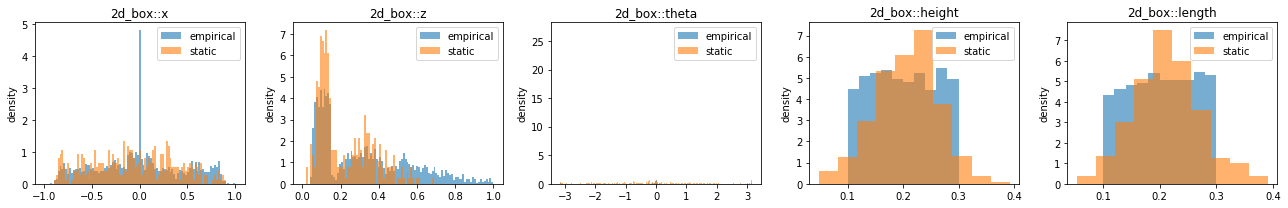

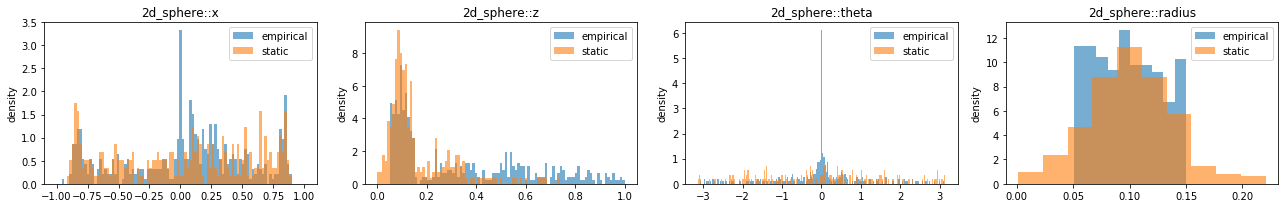

In [11]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        #params_by_object_class_nonpen[object_name],
        params_by_object_class_static[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "static"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()